In [1]:
from Flower import *

In [2]:
# initialize probability class

prior_ranges = {
    "astro_params": {
        "L_X": [38, 42],
        "NU_X_THRESH": [100, 1500],
        "ION_Tvir_MIN": [4, 5.3],
        "HII_EFF_FACTOR": [10, 250]
    }
}

fiducial_parameter = {
    "user_params": {
        "HII_DIM": 40,
        "BOX_LEN": 160,
        "N_THREADS": 1,
        "USE_INTERPOLATION_TABLES": True,
    },
    "flag_options": {
        "USE_TS_FLUCT": False,
        "INHOMO_RECO": False
    },
    "astro_params": {
        "INHOMO_RECO": False,
        "L_X": 40,
        "NU_X_THRESH": 500,
        "ION_Tvir_MIN": 5,
        "HII_EFF_FACTOR": 30
    },
    "make_statistics": False,
}

probability = Probability(prior_ranges=prior_ranges, z_eval=np.linspace(5.5,30, 25), bins=6, debug=True, 
                          fmodel_path="./emcee_data/fiducial_ps.npy", summary_statistics = '1dps')

emcee = Flower(Probability=probability, redshift=5, data_path="./emcee_data/", noise_type=[1,0,20],
                       regenerate_fiducial=True, fid_params=fiducial_parameter, debug=True)

emcee.make_fiducial()


emcee.run_emcee(threads=2, nsteps=240, walkers=24)


Set initial parameters...
initialize Simulation class...
Search for existing fiducial lightcone...
Begin lightcone simulation ...
Parameter successfully refreshed.
Current parameters are:
astro_params: AstroParams:
    ALPHA_ESC       : -0.5
    ALPHA_STAR      : 0.5
    ALPHA_STAR_MINI : 0.5
    A_LW            : 2.0
    A_VCB           : 1.0
    BETA_LW         : 0.6
    BETA_VCB        : 1.8
    F_ESC10         : 0.1
    F_ESC7_MINI     : 0.01
    F_H2_SHIELD     : 0.0
    F_STAR10        : 0.05011872336272722
    F_STAR7_MINI    : 0.01
    HII_EFF_FACTOR  : 30
    ION_Tvir_MIN    : 100000
    L_X             : 10000000000000000000000000000000000000000
    L_X_MINI        : 1e+40
    M_TURN          : 501187233.6272715
    NU_X_THRESH     : 500
    N_RSD_STEPS     : 20
    R_BUBBLE_MAX    : 15.0
    X_RAY_SPEC_INDEX: 1.0
    X_RAY_Tvir_MIN  : 100000
    t_STAR          : 0.5
    
cosmo_params: CosmoParams:
    OMb        : 0.04897468161869667
    OMm        : 0.30964144154550644
   

/home/deck/Documents/masterstuff/p21cm-fast/lib/python3.11/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)


PS is [[  15.04820722   76.18389595  268.61790779  666.98491891 1307.52120297
  2233.69344516]
 [  24.74463804   82.34404235  279.82208644  677.55152918 1307.63974968
  2119.00924767]
 [  28.24672928   87.11423282  276.59831777  695.68800485 1321.52665309
  2359.60404507]
 [  18.76981599   92.1840363   280.27351112  685.80659738 1330.39450627
  2157.81456006]
 [  16.09953589   85.64277948  278.94860112  692.6035732  1319.05479428
  2273.56024667]
 [  13.54481178   78.57982134  273.05815887  669.83128468 1343.54556474
  2203.96656924]
 [  16.21988481   78.53658539  275.84794109  672.76191775 1312.94954352
  2287.4397509 ]
 [  18.11694294   80.32031393  274.57943226  675.03004787 1295.10927897
  2269.9758776 ]
 [  19.15360122   83.33797387  273.27357551  670.01026162 1330.13094753
  2174.32786165]
 [  19.19397221   84.23867902  276.89989823  677.86495488 1326.5748266
  2051.99521205]
 [  18.93936241   80.21525325  268.78913346  675.21308063 1273.45588376
  2203.57374828]
 [  18.79426129 

'res = calculate_ps(lc = lcb, lc_redshifts=lc.lightcone_redshifts,box_length=lc.user_params.BOX_LEN,\n                   box_side_shape=lc.user_params.HII_DIM,\n                   log_bins=True, zs=np.linspace(6,34, 30), calc_1d=True, calc_2d=False,\n                   nbins_1d=6, bin_ave=True, k_weights=ignore_zero_absk)'

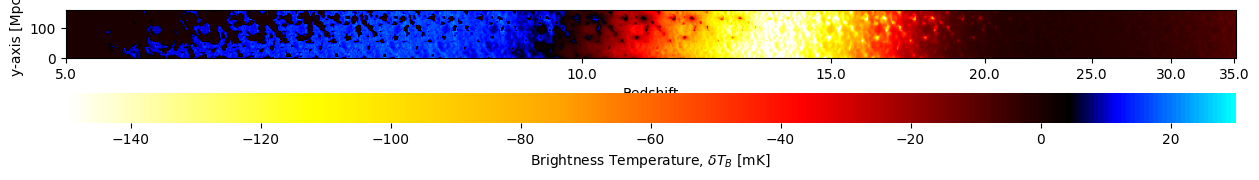

In [4]:

lc = p21c.outputs.LightCone.read("/home/deck/Documents/masterstuff/data/mcmc_res/data_emcee_1d/fiducial_cone.h5")
lcb = lc.brightness_temp

p21c.plotting.lightcone_sliceplot(lc)

'''res = calculate_ps(lc = lcb, lc_redshifts=lc.lightcone_redshifts,box_length=lc.user_params.BOX_LEN,
                   box_side_shape=lc.user_params.HII_DIM,
                   log_bins=True, zs=np.linspace(6,34, 30), calc_1d=True, calc_2d=False,
                   nbins_1d=6, bin_ave=True, k_weights=ignore_zero_absk)'''

/home/deck/Documents/masterstuff/p21cm-fast/lib/python3.11/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)


{'k': array([0.06801748, 0.14932925, 0.23351562, 0.32049753, 0.4109539 ,
       0.50105834, 0.59198223, 0.68306492, 0.7720371 , 0.86036357,
       0.95020922, 1.03762972, 1.12326531, 1.20914794, 1.28753583]), 'ps_1D': array([[5.16294495e+00, 7.21255151e+00, 4.76726403e+00, 3.64543609e+00,
        3.47837460e+00, 3.11612112e+00, 3.06192732e+00, 3.37180203e+00,
        3.89888008e+00, 4.47643189e+00, 5.35624671e+00, 6.34467626e+00,
        7.55624575e+00, 9.39692405e+00, 8.83204231e+00],
       [9.05811814e+00, 1.61866708e+01, 1.76733371e+01, 1.66768446e+01,
        1.48462924e+01, 1.34738354e+01, 1.32722150e+01, 1.25738291e+01,
        1.33806887e+01, 1.43334122e+01, 1.58541987e+01, 1.78798200e+01,
        2.09603535e+01, 2.38061970e+01, 3.17353891e+01],
       [1.13177395e+00, 5.83261486e+00, 9.62934537e+00, 1.18151915e+01,
        1.24904794e+01, 1.13623845e+01, 1.11808393e+01, 1.08170843e+01,
        1.08812154e+01, 1.05665999e+01, 1.13203168e+01, 1.22973359e+01,
        1.34879214e+

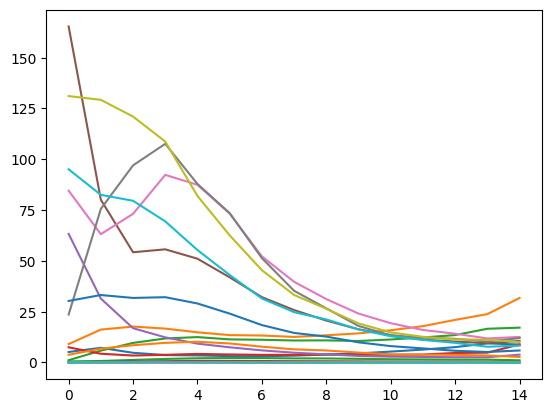

In [6]:
res = calculate_ps(lc = lc.lightcones['brightness_temp'] , lc_redshifts=lc.lightcone_redshifts, 
                           box_length=lc.user_params.BOX_LEN, box_side_shape=lc.user_params.HII_DIM,
                           log_bins=False, zs = np.linspace(5.5,30, 20), calc_1d=True, calc_2d=False,
                            bin_ave=True, k_weights=ignore_zero_absk, nbins_1d=15)

print(res)
plt.plot(res['ps_1D'].T)
print(np.isnan(res['ps_1D']).any())

In [16]:
import h5py
print(lc.lightcones['brightness_temp'])
lc.lightcones['brightness_temp'] = np.zeros(lcb.shape)
'''p21c.LightCone(redshift=lc.lightcone_redshifts,
               distances=lc.lightcone_distances,
               user_params=lc.user_params,
               cosmo_params=lc.cosmo_params,
               astro_params=lc.astro_params,
               flag_options=lc.flag_options,
               random_seed=lc.random_seed,
               lightcones=lc.lig)'''
lc.save("test.h5", clobber=True)
print(lc.brightness_temp)
#f = h5py.File('test.h5', 'rw')


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[ 0.    

In [15]:
print(p21c.outputs.LightCone.read("/home/deck/Documents/masterstuff/21cm-wrapper/test.h5").lightcones['brightness_temp'] )

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


NameError: name 'h5py' is not defined

In [30]:
p21c.outputs.LightCone.save(lc, 'test.h5', clobber=True)

'/home/deck/Documents/masterstuff/21cm-wrapper/test.h5'

[[[ 0.          0.          0.         ... 51.322292   48.731354
   48.965706  ]
  [ 0.          0.          0.         ... 48.27519    47.997135
   49.095825  ]
  [ 0.          0.          0.         ... 48.59385    50.703506
   52.15148   ]
  ...
  [11.509027    8.87871     7.8348923  ... 51.03896    49.553936
   46.822327  ]
  [ 0.          0.409841    7.672013   ... 52.883198   51.031216
   48.800125  ]
  [ 0.          0.          0.         ... 53.54485    49.785694
   49.427845  ]]

 [[ 0.          0.          0.         ... 49.0527     48.38018
   49.40539   ]
  [ 0.          0.          0.         ... 45.326733   46.892998
   49.813236  ]
  [ 0.          0.          0.         ... 45.21384    47.193672
   51.93413   ]
  ...
  [ 8.42699     9.981974    7.8032856  ... 49.52614    47.71123
   47.543663  ]
  [ 0.          0.6312858   6.8351755  ... 51.98788    49.331703
   48.22312   ]
  [ 0.          0.          0.         ... 52.17527    49.837063
   50.082428  ]]

 [[ 0.        

In [4]:
{'global_params': {'M_WDM': 3.501515617898722}, 
 'cosmo_params': {'OMm': 0.14078494774504743}, 
 'astro_params': {'L_X': 2.093953125940754, 
                  'NU_X_THRESH': 453.94456146918685, 
                  'ION_Tvir_MIN': 0.25907883271173016, 
                  'HII_EFF_FACTOR': 192.22061520453673}}

Init signature: range(self, /, *args, **kwargs)
Docstring:     
range(stop) -> range object
range(start, stop[, step]) -> range object

Return an object that produces a sequence of integers from start (inclusive)
to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
These are exactly the valid indices for a list of 4 elements.
When step is given, it specifies the increment (or decrement).
Type:           type
Subclasses:     

In [2]:
from powerbox import get_power
import numpy as np
data = np.random.rand(100,100,100)
from matplotlib import pyplot as plt

get_power?
#ps, k, var = get_power(data, boxlength=100, bin_ave=True, get_variance=True, 
#                       ignore_zero_mode=True)

Signature:
get_power(
    deltax,
    boxlength,
    deltax2=None,
    N=None,
    a=1.0,
    b=1.0,
    remove_shotnoise=True,
    vol_normalised_power=True,
    bins=None,
    res_ndim=None,
    weights=None,
    weights2=None,
    dimensionless=True,
    bin_ave=True,
    get_variance=False,
    log_bins=False,
    ignore_zero_mode=False,
    k_weights=1,
    nthreads=None,
    prefactor_fnc=None,
    interpolation_method=None,
    interp_points_generator=None,
    return_sumweights=False,
)
Docstring:
Calculate isotropic power spectrum of a field, or cross-power of two similar fields.

This function, by default, conforms to typical cosmological power spectrum
conventions -- normalising by the volume of the box and removing shot noise if
applicable. These options are configurable.

Parameters
----------
deltax : array-like
    The field on which to calculate the power spectrum . Can either be arbitrarily
    n-dimensional, or 2-dimensional with the first being the number of spatial


In [13]:
#field = lightcone.brightness_temp[:,:,zbins[bin]:zbins[bin+1]]
import py21cmfast as p21c
from py21cmfast_tools import calculate_ps
lightcone = p21c.outputs.LightCone.read("../data/res_comp/110_res_False_.h5")
field = lightcone.brightness_temp[:,:, 1100:1400]
boxlength = lightcone.cell_size*np.asarray(lightcone.brightness_temp[:,:1100:1400].shape)

ps_2d, kperp, var, kpar, sumweights = get_power(field, boxlength=boxlength, res_ndim=2, bins = 15, 
                        ignore_zero_mode=True, bin_ave=True, get_variance=True, return_sumweights=True) 

print(ps_2d.shape)
print(kperp.shape)
print(kpar.shape)
print(var.shape)
print(sumweights[0].shape)

(15, 300)
(15,)
(15,)
(15, 300)
(300,)


In [9]:
#field = lightcone.brightness_temp[:,:,zbins[bin]:zbins[bin+1]]
import py21cmfast as p21c
lightcone = p21c.outputs.LightCone.read("../data/res_comp/110_res_False_.h5")
field = lightcone.brightness_temp[:,:, 1100:1400]
boxlength = lightcone.cell_size*np.asarray(lightcone.brightness_temp[:,:500:800].shape)

res = calculate_ps(lc = field, lc_redshifts=lightcone.lightcone_redshifts, box_length=200, box_side_shape=110, nbins = 20, log_bins=False)

/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast_tools/lc2ps.py:280: RuntimeWarning: Mean of empty slice
  new_ps[:, i] = np.nanmean(ps[:, m], axis=1)
/home/potato/Documents/projects/master/p21cm-venv/lib/python3.11/site-packages/py21cmfast_tools/lc2ps.py:348: RuntimeWarning: Mean of empty slice
  lastnan_par = np.where(np.isnan(np.nanmean(rebinned_ps, axis=0)))[0][-1] + 1


In [14]:
res.keys()
print(res['full_ps_2D'].shape)
print(res['final_ps_2D'].shape)

(6, 20, 110)
(6, 20, 12)


In [1]:
import numpy as np
from powerbox.tools import (
    _magnitude_grid,
    above_mu_min_angular_generator,
    get_power,
    ignore_zero_ki,
    power2delta,
    regular_angular_generator,
)


def calculate_ps(  # noqa: C901
    lc,
    lc_redshifts,
    box_length,
    box_side_shape=None,
    zs=None,
    chunk_size=None,
    chunk_skip=37,
    calc_2d=True,
    nbins=50,
    k_weights=ignore_zero_ki,
    postprocess=True,
    kpar_bins=None,
    log_bins=True,
    crop=None,
    calc_1d=False,
    nbins_1d=14,
    calc_global=False,
    mu=None,
    bin_ave=True,
    interp=None,
    prefactor_fnc=power2delta,
    interp_points_generator=None,
):
    r"""Calculate power spectra from a lightcone.

    Parameters
    ----------
    lc : np.ndarray
        The lightcone whose power spectrum we want to calculate.
        The lightcone should be a 3D array with shape
        [box_side_shape, box_side_shape, len(lc_redshifts)].
    lc_redshifts : np.ndarray
        The redshifts of the lightcone.
    box_length : float
        The side length of the box in cMpc.
    box_side_shape : int, optional
        The number of pixels in one side of the box
        (HII_DIM parameter in 21cmFAST).
    zs : np.ndarray, optional
        The redshifts at which to calculate the power spectrum.
        If None, the lightcone is broken up into chunks using arguments
        chunk_skip and chunk_size.
    chunk_size : int, optional
        The size of the chunks to break the lightcone into.
        If None, the chunk is assumed to be a cube i.e. chunk_size = box_side_shape.
    chunk_skip : int, optional
        The number of lightcone slices to skip between chunks. Default is 37.
    calc_2d : bool, optional
        If True, calculate the 2D power spectrum.
    nbins : int, optional
        The number of bins to use for the kperp axis of the 2D PS.
    k_weights : callable, optional
        A function that takes a frequency tuple and returns
        a boolean mask for the k values to ignore.
        See powerbox.tools.ignore_zero_ki for an example
        and powerbox.tools.get_power documentation for more details.
        Default is powerbox.tools.ignore_zero_ki, which excludes
        the power any k_i = 0 mode.
        Typically, only the central zero mode |k| = 0 is excluded,
        in which case use powerbox.tools.ignore_zero_absk.
    postprocess : bool, optional
        If True, postprocess the 2D PS.
        This step involves cropping out empty bins and/or log binning the kpar axis.
    kpar_bins : int or np.ndarray, optional
        Affects only the postprocessing step.
        The number of bins or the bin edges to use for binning the kpar axis.
        If None, produces 16 bins.
    log_bins : bool, optional
        Affects only the postprocessing step. If True, log bin the kpar axis.
    crop : list, optional
        Affects only the postprocessing step.
        The crop range for the (log-binned) PS. If None, crops out only the empty bins.
    calc_1d : bool, optional
        If True, calculate the 1D power spectrum.
    nbins_1d : int, optional
        The number of bins on which to calculate 1D PS.
    calc_global : bool, optional
        If True, calculate the global brightness temperature.
    mu : float, optional
        The minimum value of
        :math:`\\cos(\theta), \theta = \arctan (k_\\perp/k_\\parallel)`
        for all calculated PS.
        If None, all modes are included.
    bin_ave : bool, optional
        If True, return the center value of each kperp and kpar bin
        i.e. len(kperp) = ps_2d.shape[0].
        If False, return the left edge of each bin
        i.e. len(kperp) = ps_2d.shape[0] + 1.
    interp : str, optional
        If True, use linear interpolation to calculate the PS
        at the points specified by interp_points_generator.
        Note that this significantly slows down the calculation.
    prefactor_fnc : callable, optional
        A function that takes a frequency tuple and returns the prefactor
        to multiply the PS with.
        Default is powerbox.tools.power2delta, which converts the power
        P [mK^2 Mpc^{-3}] to the dimensionless power :math:`\\delta^2` [mK^2].
    interp_points_generator : callable, optional
        A function that generates the points at which to interpolate the PS.
        See powerbox.tools.get_power documentation for more details.
    """
    # Split the lightcone into chunks for each redshift bin
    # Infer HII_DIM from lc side shape
    if box_side_shape is None:
        box_side_shape = lc.shape[0]
    if zs is None:
        if chunk_size is None:
            chunk_size = box_side_shape
        n_slices = lc.shape[-1]
        chunk_indices = list(range(0, n_slices - chunk_size, chunk_skip))
    else:
        if chunk_size is None:
            chunk_size = box_side_shape
        chunk_indices = np.array(
            np.max(
                [
                    np.zeros_like(zs),
                    np.array([np.argmin(abs(lc_redshifts - z)) for z in zs])
                    - chunk_size // 2,
                ],
                axis=0,
            ),
            dtype=np.int32,
        )
    zs = []  # all redshifts that will be computed
    lc_ps_2d = []
    clean_lc_ps_2d = []
    if calc_global:
        tb = []
    if calc_1d:
        lc_ps_1d = []
    out = {}

    if interp:
        interp = "linear"

    for i in chunk_indices:
        start = i
        end = i + chunk_size
        if end > len(lc_redshifts):
            shift_it_back_by_a_few_bins = end - len(lc_redshifts)
            start -= shift_it_back_by_a_few_bins
            end = len(lc_redshifts)
        chunk = lc[..., start:end]
        zs.append(lc_redshifts[(start + end) // 2])
        if calc_global:
            tb.append(np.mean(chunk))
        if calc_2d:
            ps_2d, kperp, nmodes, kpar = get_power(
                chunk,
                (box_length, box_length, box_length * chunk.shape[-1] / box_side_shape),
                res_ndim=2,
                bin_ave=bin_ave,
                bins=nbins,
                log_bins=log_bins,
                nthreads=1,
                k_weights=k_weights,
                prefactor_fnc=prefactor_fnc,
                interpolation_method=interp,
                return_sumweights=True,
            )
            if postprocess:
                clean_ps_2d, clean_kperp, clean_kpar, clean_nmodes = postprocess_ps(
                    ps_2d,
                    kperp,
                    kpar,
                    log_bins=log_bins,
                    kpar_bins=kpar_bins,
                    crop=crop.copy() if crop is not None else crop,
                    kperp_modes=nmodes,
                    return_modes=True,
                )
                clean_lc_ps_2d.append(clean_ps_2d)

            lc_ps_2d.append(ps_2d)

        if calc_1d:
            if mu is not None:
                if interp is None:

                    def mask_fnc(freq, absk):
                        kz_mesh = np.zeros((len(freq[0]), len(freq[1]), len(freq[2])))
                        kz = freq[2]
                        for i in range(len(kz)):
                            kz_mesh[:, :, i] = kz[i]
                        phi = np.arccos(kz_mesh / absk)
                        mu_mesh = abs(np.cos(phi))
                        kmag = _magnitude_grid([c for i, c in enumerate(freq) if i < 2])
                        return np.logical_and(mu_mesh > mu, ignore_zero_ki(freq, kmag))

                    k_weights1d = mask_fnc

                if interp is not None:
                    k_weights1d = ignore_zero_ki

                    interp_points_generator = above_mu_min_angular_generator(mu=mu)
            else:
                k_weights1d = ignore_zero_ki
                if interp is not None:
                    interp_points_generator = regular_angular_generator()
            ps_1d, k, nmodes_1d = get_power(
                chunk,
                (box_length, box_length, box_length * chunk.shape[-1] / box_side_shape),
                bin_ave=bin_ave,
                bins=nbins_1d,
                log_bins=log_bins,
                k_weights=k_weights1d,
                prefactor_fnc=prefactor_fnc,
                interpolation_method=interp,
                interp_points_generator=interp_points_generator,
                return_sumweights=True,
            )
            lc_ps_1d.append(ps_1d)

    if calc_1d:
        out["k"] = k
        out["ps_1D"] = np.array(lc_ps_1d)
        out["Nmodes_1D"] = nmodes_1d
        out["mu"] = mu
    if calc_2d:
        out["full_kperp"] = kperp
        out["full_kpar"] = kpar
        out["full_ps_2D"] = np.array(lc_ps_2d)
        out["final_ps_2D"] = np.array(clean_lc_ps_2d)
        out["final_kpar"] = clean_kpar
        out["final_kperp"] = clean_kperp
        out["full_Nmodes"] = nmodes
        out["final_Nmodes"] = clean_nmodes
    if calc_global:
        out["global_Tb"] = np.array(tb)
    out["redshifts"] = np.array(zs)

    return out


def log_bin(ps, kperp, kpar, bins=None):
    r"""
    Log bin a 2D PS along the kpar axis and crop out empty bins in both axes.

    Parameters
    ----------
    ps : np.ndarray
        The 2D power spectrum of shape [len(kperp), len(kpar)].
    kperp : np.ndarray
        Values of kperp.
    kpar : np.ndarray
        Values of kpar.
    bins : np.ndarray or int, optional
        The number of bins or the bin edges to use for binning the kpar axis.
        If None, produces 16 bins logarithmically spaced between
        the minimum and maximum `kpar` supplied.

    """
    if bins is None:
        bins = np.logspace(np.log10(kpar[0]), np.log10(kpar[-1]), 17)
    elif isinstance(bins, int):
        bins = np.logspace(np.log10(kpar[0]), np.log10(kpar[-1]), bins + 1)
    elif isinstance(bins, (np.ndarray, list)):
        bins = np.array(bins)
    else:
        raise ValueError("Bins should be np.ndarray or int")
    modes = np.zeros(len(bins) - 1)
    new_ps = np.zeros((len(kperp), len(bins) - 1))
    for i in range(len(bins) - 1):
        m = np.logical_and(kpar > bins[i], kpar < bins[i + 1])
        new_ps[:, i] = np.nanmean(ps[:, m], axis=1)
        modes[i] = np.sum(m)
    bin_centers = np.exp((np.log(bins[1:]) + np.log(bins[:-1])) / 2)
    return new_ps, kperp, bin_centers, modes


def postprocess_ps(
    ps,
    kperp,
    kpar,
    kpar_bins=None,
    log_bins=True,
    crop=None,
    kperp_modes=None,
    return_modes=False,
):
    """
    Postprocess a 2D PS by cropping out empty bins and log binning the kpar axis.

    Parameters
    ----------
    ps : np.ndarray
        The 2D power spectrum of shape [len(kperp), len(kpar)].
    kperp : np.ndarray
        Values of kperp.
    kpar : np.ndarray
        Values of kpar.
    kpar_bins : np.ndarray or int, optional
        The number of bins or the bin edges to use for binning the kpar axis.
        If None, produces 16 bins log spaced between the min and max `kpar` supplied.
    log_bins : bool, optional
        If True, log bin the kpar axis.
    crop : list, optional
        The crop range for the log-binned PS. If None, crops out all empty bins.
    kperp_modes : np.ndarray, optional
        The number of modes in each kperp bin.
    return_modes : bool, optional
        If True, return a grid with the number of modes in each bin.
        Requires kperp_modes to be supplied.
    """
    kpar = kpar[0]
    m = kpar > 1e-10
    if ps.shape[0] < len(kperp):
        if log_bins:
            kperp = np.exp((np.log(kperp[1:]) + np.log(kperp[:-1])) / 2.0)
        else:
            kperp = (kperp[1:] + kperp[:-1]) / 2
    kpar = kpar[m]
    ps = ps[:, m]
    mkperp = ~np.isnan(kperp)
    if kperp_modes is not None:
        kperp_modes = kperp_modes[mkperp]
    kperp = kperp[mkperp]
    ps = ps[mkperp, :]

    # Bin kpar in log
    rebinned_ps, kperp, log_kpar, kpar_weights = log_bin(
        ps, kperp, kpar, bins=kpar_bins
    )
    if crop is None:
        crop = [0, rebinned_ps.shape[0] + 1, 0, rebinned_ps.shape[1] + 1]
    # Find last bin that is NaN and cut out all bins before
    try:
        lastnan_perp = np.where(np.isnan(np.nanmean(rebinned_ps, axis=1)))[0][-1] + 1
        crop[0] = crop[0] + lastnan_perp
    except IndexError:
        pass
    try:
        lastnan_par = np.where(np.isnan(np.nanmean(rebinned_ps, axis=0)))[0][-1] + 1
        crop[2] = crop[2] + lastnan_par
    except IndexError:
        pass
    if kperp_modes is not None:
        final_kperp_modes = kperp_modes[crop[0] : crop[1]]
        kpar_grid, kperp_grid = np.meshgrid(
            kpar_weights[crop[2] : crop[3]], final_kperp_modes
        )

        nmodes = np.sqrt(kperp_grid**2 + kpar_grid**2)
        if return_modes:
            return (
                rebinned_ps[crop[0] : crop[1]][:, crop[2] : crop[3]],
                kperp[crop[0] : crop[1]],
                log_kpar[crop[2] : crop[3]],
                nmodes,
            )
    else:
        return (
            rebinned_ps[crop[0] : crop[1]][:, crop[2] : crop[3]],
            kperp[crop[0] : crop[1]],
            log_kpar[crop[2] : crop[3]],
        )

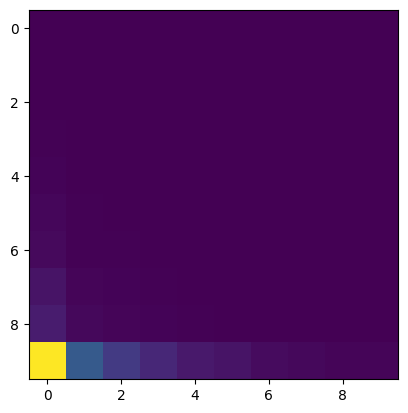

In [141]:
plt.imshow(ps)

In [130]:
print(np.mean(ps_par, axis=(1,2))*k_par)
print(np.mean(ps_perp, axis=(1))*k_perp)

[643.6622764  155.42738546 212.68190662 176.0704072  174.62668773
 116.84848675 102.66020138  65.60355855  57.90914648  45.13445904]
[1152.37029972  316.18161984  185.39975258  120.25067345   73.43607588
   53.66585131   32.10725983   21.23798507   15.061911     14.75567558]


-107.58163


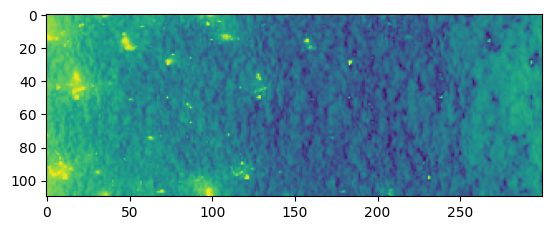

In [123]:
print(field[:,:,0].min())
plt.imshow(field[0,:,:])

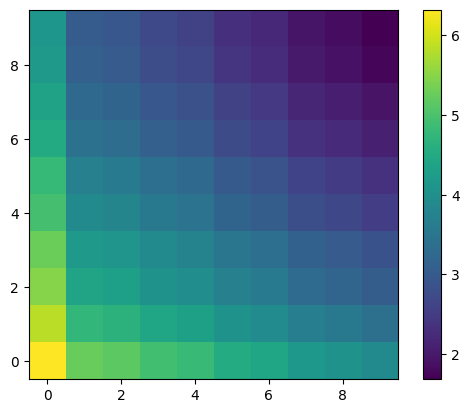

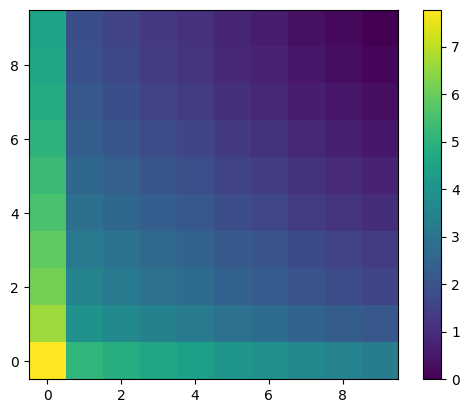

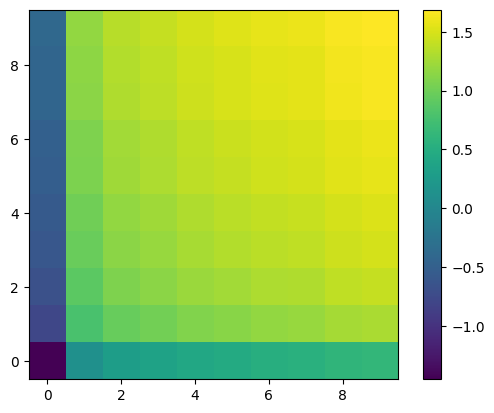

In [116]:
plt.imshow(np.log10(ps), origin='lower')
plt.colorbar()  
plt.show()
plt.imshow(np.log10(ps_var), origin='lower')
plt.colorbar()
plt.show()
plt.imshow(np.log10(ps/ps_var), origin='lower')
plt.colorbar()
plt.show()

In [99]:
field.shape

(110, 110, 300)

In [65]:
ps_var = np.outer(var_perp_*k_perp**2, var_par_*k_par).T

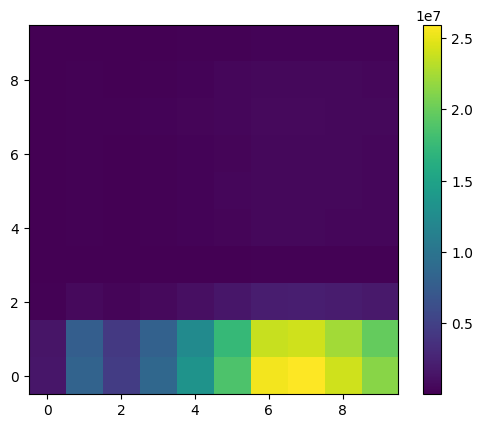

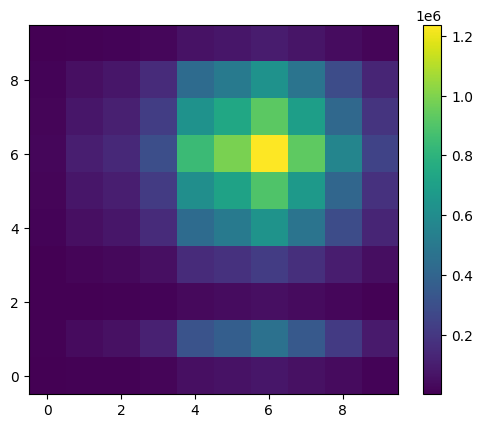

In [66]:
plt.imshow(ps, origin='lower')
plt.colorbar()  
plt.show()
plt.imshow(ps_var, origin='lower')
plt.colorbar()
plt.show()